# Arquitectura Unet construida desde cero para la segmentación de la mitocondria en imágenes de microscopía electrónica.

Para este ejemplo se uso un subconjunto pequeño de la base de datos disponible en: https://www.epfl.ch/labs/cvlab/data/data-em/

##1. Primero se carga la base de datos.

Se cargan dos conjunto de imágenes de tamaño 768x1024 con sus respectivas etiquetas. Las etiquetas son imágenes bnarias que indican cuáles pixeles corresponden a una mitocondria.

In [1]:
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing.tif
!wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing_groundtruth.tif

--2024-11-14 00:26:37--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) [application/octet-stream]
Saving to: ‘training.tif’

training.tif        100%[===================>] 123.90M   955KB/s    in 3m 58s  

2024-11-14 00:30:36 (533 KB/s) - ‘training.tif’ saved [129919357/129919357]

--2024-11-14 00:30:36--  https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
Resolving documents.epfl.ch (documents.epfl.ch)... 128.178.222.197, 2001:620:618:1de:1:80b2:dec5:1
Connecting to documents.epfl.ch (documents.epfl.ch)|128.178.222.197|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129919357 (124M) 

In [2]:
!pip install patchify

In [19]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import tifffile as tiff
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import tensorflow as tf

##2. División de imágenes.

Las imágenes usadas tienen un gran tamaño, de esta forma, para agilizar los cálculos, cada imagen se divide en sub-imágenes de tamaño 256x256.

In [4]:
# Para agilizar los cálculos, solo se usarán los datos de entrenamiento.
image_stack_1 = tiff.imread('training.tif') # Imágenes de entrenamiento
mask_stack_1 = tiff.imread('training_groundtruth.tif') # Máscaras de entrenamiento
# image_stack_2 = tiff.imread('testing.tif')
# mask_stack_2 = tiff.imread('testing_groundtruth.tif')

In [6]:
# Son arreglos de tamaño 165x768x1024, esto implica que hay 165 imágenes, cada
# una con tamaño 768x1024
image_stack_1.shape

(165, 768, 1024)

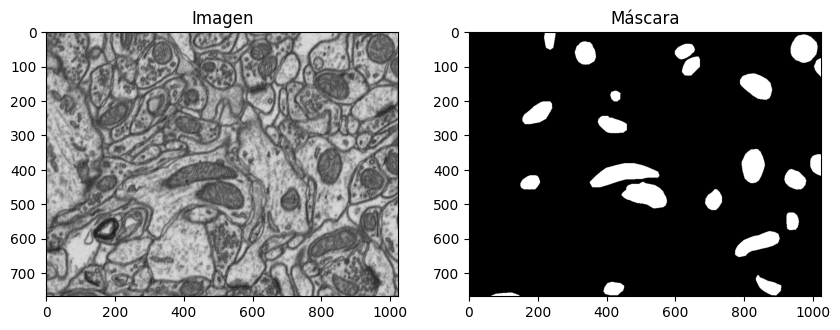

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image_stack_1[0,:,:], cmap='gray')
ax1.set_title('Imagen')
ax2.imshow(mask_stack_1[0,:,:], cmap='gray')
ax2.set_title('Máscara')
fig.show()

In [8]:
# Se dividen las imágenes en imágenes más pequeñas de tamaño 256x256

def div_patches(I, size = 256, mask=0):

  all_img_patches = []
  for img in range(I.shape[0]):

      large_image = I[img]

      patches_img = patchify(large_image, (size, size), step=size)  #Step=256 for 256 patches means no overlap


      for i in range(patches_img.shape[0]):
          for j in range(patches_img.shape[1]):

              single_patch_img = patches_img[i,j,:,:]
              single_patch_img = (single_patch_img.astype('float32')) / 255.

              all_img_patches.append(single_patch_img)

  images = np.array(all_img_patches)
  images = np.expand_dims(images, -1)
  return images

In [9]:
images = div_patches(image_stack_1[:12,:,:], size = 256, mask=0) # Imágenes divididas
masks  = div_patches(mask_stack_1[:12,:,:], size = 256, mask=1) # Máscaras divididas

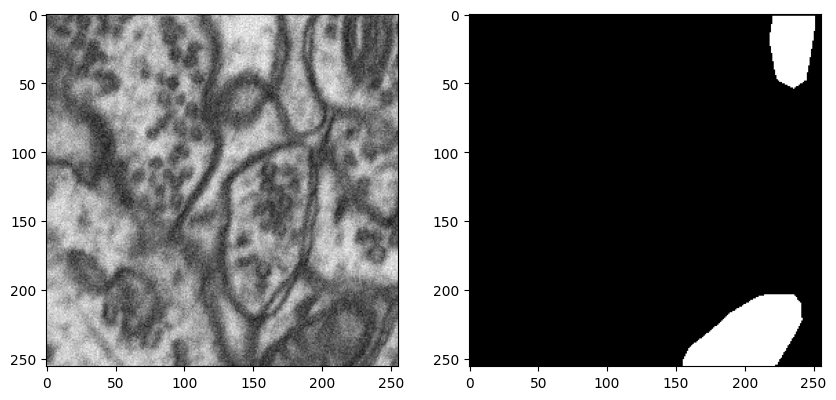

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(images[0,:,:], cmap='gray')
ax2.imshow(masks[0,:,:], cmap='gray')

In [11]:
# Se divide en train y test.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size = 0.3, random_state = 0)

In [12]:
h = images.shape[1]
w  = images.shape[2]
c = images.shape[3]
print(h, w, c) #tamaño de las imágenes

256 256 1


##3. Se define el modelo UNet básico.

In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

In [14]:
#Definir bloques convolucionales.
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x) # Se usa para normalizar las salidas de las capas
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

#Definir bloques convolucionales + max pooling.
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Codificador.
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

# Decodificador
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#UNet
def build_unet(input_shape):
    inputs = Input(input_shape) #256x256

    s1, p1 = encoder_block(inputs, 64) #128x128x64
    s2, p2 = encoder_block(p1, 128) #64x64x128
    s3, p3 = encoder_block(p2, 256) #32x32x256
    s4, p4 = encoder_block(p3, 512) #16x16x512

    b1 = conv_block(p4, 1024) #Puente (cuello de botella) 16x16x1024

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binario

    model = Model(inputs, outputs, name="U-Net")
    return model

In [16]:
input_shape = (h, w, c)
model = build_unet(input_shape)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 256, 256, 64)   │            256 │ conv2d_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 256, 256, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 128, 128, 128)  │            512 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 128, 128, 128)  │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_21             │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5      

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

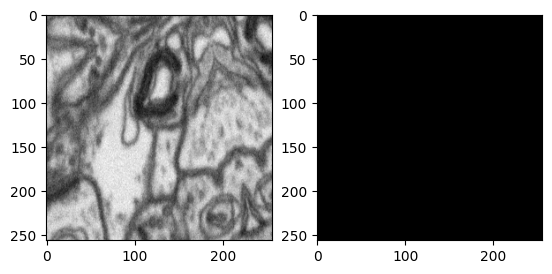

In [24]:
# Data augmentation.

seed=24
from keras.src.legacy.preprocessing.image import ImageDataGenerator # Use legacy import for ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarizar la salida.

image_data_generator = ImageDataGenerator(**img_data_gen_args)

batch_size= 8

image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = next(image_generator) # Use next() instead of .next()
y = next(mask_generator) # Use next() instead of .next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0],cmap='gray')
    plt.show()

In [25]:
steps_per_epoch = 3*(len(X_train))//batch_size

# history = model.fit_generator(my_generator, validation_data=validation_datagen,
#                     steps_per_epoch=steps_per_epoch,
#                     validation_steps=steps_per_epoch, epochs=25, verbose=2)

# Use model.fit() directly:
history = model.fit(my_generator, validation_data=validation_datagen,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=steps_per_epoch, epochs=25, verbose=2)


Epoch 1/25
37/37 - 132s - 4s/step - accuracy: 0.8718 - loss: 0.3400 - val_accuracy: 0.0688 - val_loss: 1091.1396
Epoch 2/25
37/37 - 22s - 597ms/step - accuracy: 0.9553 - loss: 0.1476 - val_accuracy: 0.8726 - val_loss: 0.4502
Epoch 3/25
37/37 - 22s - 600ms/step - accuracy: 0.9598 - loss: 0.1237 - val_accuracy: 0.3866 - val_loss: 4.6572
Epoch 4/25
37/37 - 22s - 582ms/step - accuracy: 0.9617 - loss: 0.1107 - val_accuracy: 0.0918 - val_loss: 41.2651
Epoch 5/25
37/37 - 22s - 586ms/step - accuracy: 0.9629 - loss: 0.1087 - val_accuracy: 0.7993 - val_loss: 0.4897
Epoch 6/25
37/37 - 22s - 592ms/step - accuracy: 0.9702 - loss: 0.0862 - val_accuracy: 0.8697 - val_loss: 0.3608
Epoch 7/25
37/37 - 22s - 591ms/step - accuracy: 0.9618 - loss: 0.1057 - val_accuracy: 0.1505 - val_loss: 8.0707
Epoch 8/25
37/37 - 22s - 595ms/step - accuracy: 0.9716 - loss: 0.0800 - val_accuracy: 0.7571 - val_loss: 0.6726
Epoch 9/25
37/37 - 22s - 587ms/step - accuracy: 0.9712 - loss: 0.0775 - val_accuracy: 0.6887 - val_los

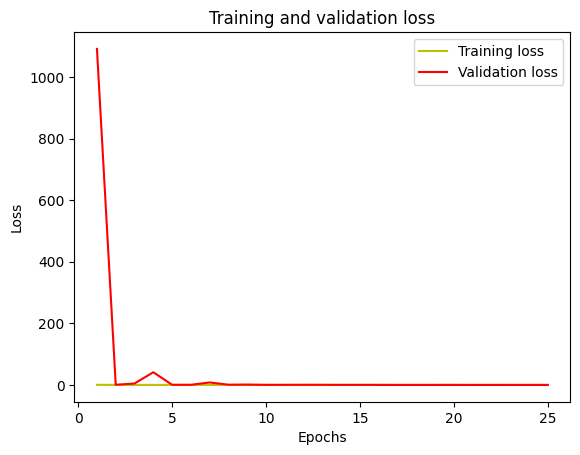

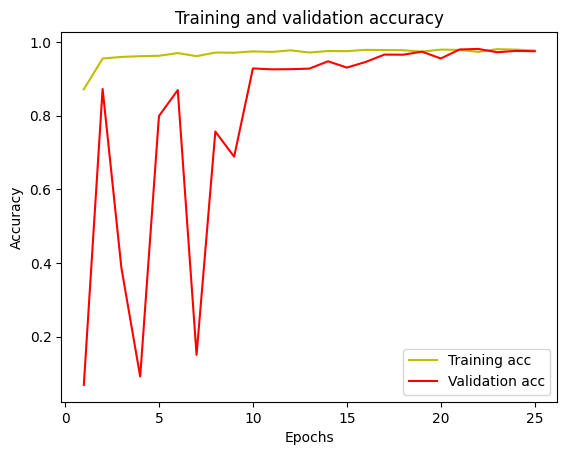

2/2 ━━━━━━━━━━━━━━━━━━━━ 52s 20s/step
IoU socre is:  0.7987501723108027


In [26]:
#plot losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#IOU (métrica de rendimiento)
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred >0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


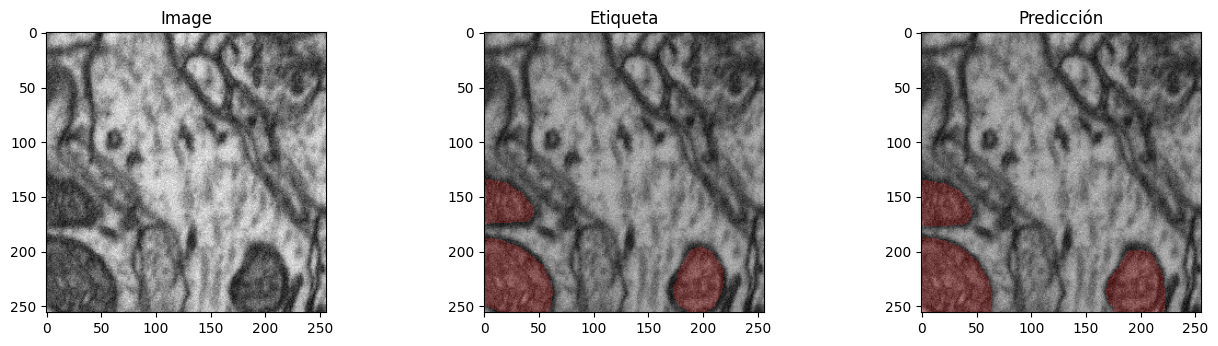

In [27]:
#Resultado de algunas imágenes
test_img_number = np.random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

# máscaras para visualizar los resultados (Etiquetas verdaderas)
ground_truth[ground_truth[:,:,0] == 0,0] = np.nan
mask_gt = np.concatenate((ground_truth*255, np.zeros_like(ground_truth), np.zeros_like(ground_truth)), axis=2)

# máscaras para visualizar los resultados (Predicciones)
prediction = np.expand_dims(prediction, -1)/1.0
prediction[prediction[:,:,0] == 0,0] = np.nan
mask_p = np.concatenate((prediction*255, np.zeros_like(prediction), np.zeros_like(prediction)), axis=2)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Etiqueta')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.imshow(mask_gt, cmap='gray', alpha=0.2)
plt.subplot(233)
plt.title('Predicción')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.imshow(mask_p, cmap='gray',alpha=0.2)

plt.show()